# Step 3: Train ML model

In this notebook we will load the training data, train the ML model, and save it.

In [1]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

# Config paths

Specify the paths and directories from which we will read and write data to. In practice we would store this in a separate file rather than duplicate it across all notebooks. For simplicity, we specify the paths in the notebook itself.

In [2]:
# Directory containing the raw data
data_sources = Path("../data_sources")

# Output processed data (i.e., the base dataset)
processed_data_dir = Path("../processed_data")

# Artifacts directory for storing the
# training data, models, pipelines etc.
artifacts_dir = Path("../artifacts")
training_dir = artifacts_dir / "training"
pipeline_dir = artifacts_dir / "pipeline"
model_dir = artifacts_dir / "model"
forecast_dir = artifacts_dir / "forecast"

# Create directories
for _dir in [model_dir, forecast_dir]:
    _dir.mkdir(exist_ok=True)

# Load data

In [3]:
f_in = training_dir / "data.parquet"
df = pd.read_parquet(f_in)
df.head()

year  month_of_year  week_of_year  \
id                            date                                            
HOBBIES_1_001_CA_1_evaluation 2013-07-13  0.25       0.545455      0.519231   
                              2013-07-14  0.25       0.545455      0.519231   
                              2013-07-15  0.25       0.545455      0.538462   
                              2013-07-16  0.25       0.545455      0.538462   
                              2013-07-17  0.25       0.545455      0.538462   

                                          week_of_month  day_of_month  \
id                            date                                      
HOBBIES_1_001_CA_1_evaluation 2013-07-13           0.25      0.400000   
                              2013-07-14           0.25      0.433333   
                              2013-07-15           0.50      0.466667   
                              2013-07-16           0.50      0.500000   
                              2013-07-17           0.50      0.533333   

                                          day_of_week  is_weekend  \
id                            date                                  
HOBBIES_1_001_CA_1_evaluation 2013-07-13     0.833333         1.0   
                              2013-07-14     1.000000         1.0   
                              2013-07-15     0.000000         0.0   
                              2013-07-16     0.166667         0.0   
                              2013-07-17     0.333333         0.0   

                                          time_since_2000-01-01 00:00:00  \
id                            date                                         
HOBBIES_1_001_CA_1_evaluation 2013-07-13                        0.348721   
                              2013-07-14                        0.349345   
                              2013-07-15                        0.349969   
                              2013-07-16                        0.350593   
                              2013-07-17                        0.351216   

                                          y_lag_1  y_lag_2  ...  \
id                            date                          ...   
HOBBIES_1_001_CA_1_evaluation 2013-07-13      0.0      0.0  ...   
                              2013-07-14      0.0      0.0  ...   
                              2013-07-15      0.0      0.0  ...   
                              2013-07-16      0.0      0.0  ...   
                              2013-07-17      0.0      0.0  ...   

                                          sell_price_lag_14  \
id                            date                            
HOBBIES_1_001_CA_1_evaluation 2013-07-13           0.309009   
                              2013-07-14           0.309009   
                              2013-07-15           0.309009   
                              2013-07-16           0.309009   
                              2013-07-17           0.309009   

                                          sell_price_lag_28  \
id                            date                            
HOBBIES_1_001_CA_1_evaluation 2013-07-13           0.309009   
                              2013-07-14           0.309009   
                              2013-07-15           0.309009   
                              2013-07-16           0.309009   
                              2013-07-17           0.309009   

                                          sell_price_mean_1_7  \
id                            date                              
HOBBIES_1_001_CA_1_evaluation 2013-07-13             0.309009   
                              2013-07-14             0.309009   
                              2013-07-15             0.309009   
                              2013-07-16             0.309009   
                              2013-07-17             0.309009   

                                          sell_price_mean_1_14  \
id                            date                               
HOBBIES_1_001_CA_

# Fit a model (or multiple models)

In [4]:
X_train = df.drop(columns=["y"])
y_train = df[["y"]]

In [5]:
# Column names must have characters [^A-Za-z0-9_] to avoid
# LightGBM special character error
import re
X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))

In [6]:
monotone_constraints = [-1 if feat == "sell_price" else 0 
                          for feat in X_train.columns
                       ]
lgb_params = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "metric": "rmse",
    "learning_rate": 0.3,
    "n_estimators": 100,
    "boost_from_average": True,
    "verbose": -1,
    "monotone_constraints": monotone_constraints,
    "n_jobs": 4,
}

In [7]:
model = LGBMRegressor(**lgb_params)

# Train model
model.fit(X=X_train, y=y_train)

# Dump model
f_out = model_dir / f"model.joblib"
joblib.dump(model, f_out)

['../artifacts/model/model.joblib']

# [OPTIONAL] Make in-sample predictions

Whilst we conveniently have the training data & fitted model in memory, let's make in-sample predictions over some of our recent observations in the training data. This can provide helpful information when debugging our models (e.g., can the model overfit on the training data?).

In [8]:
time_index = X_train.index.get_level_values(-1)
time_mask = time_index > time_index.max() - np.timedelta64(31, "D") # Let's look at last 31 days
X_train_recent = X_train.loc[time_mask]
y_train_recent = y_train.loc[time_mask]

In [9]:
# Get in-sample predictions.
y_pred_train = model.predict(X=X_train_recent)

# Convert model predictions to a dataframe.
y_pred_train = pd.DataFrame(data={"y_pred": y_pred_train, 
                                  "y": y_train_recent["y"].values}, 
                            index=X_train_recent.index)

f_out = forecast_dir / f"in_sample_predictions.parquet"
y_pred_train.to_parquet(f_out)

Plot the in-sample predictions for a random subset of time series.

In [10]:
import matplotlib.pyplot as plt

In [11]:
n_series = 12
np.random.seed(0)
ts_ids = np.random.choice(X_train_recent.index.levels[0].values, 
                          size=n_series,
                          replace=False)

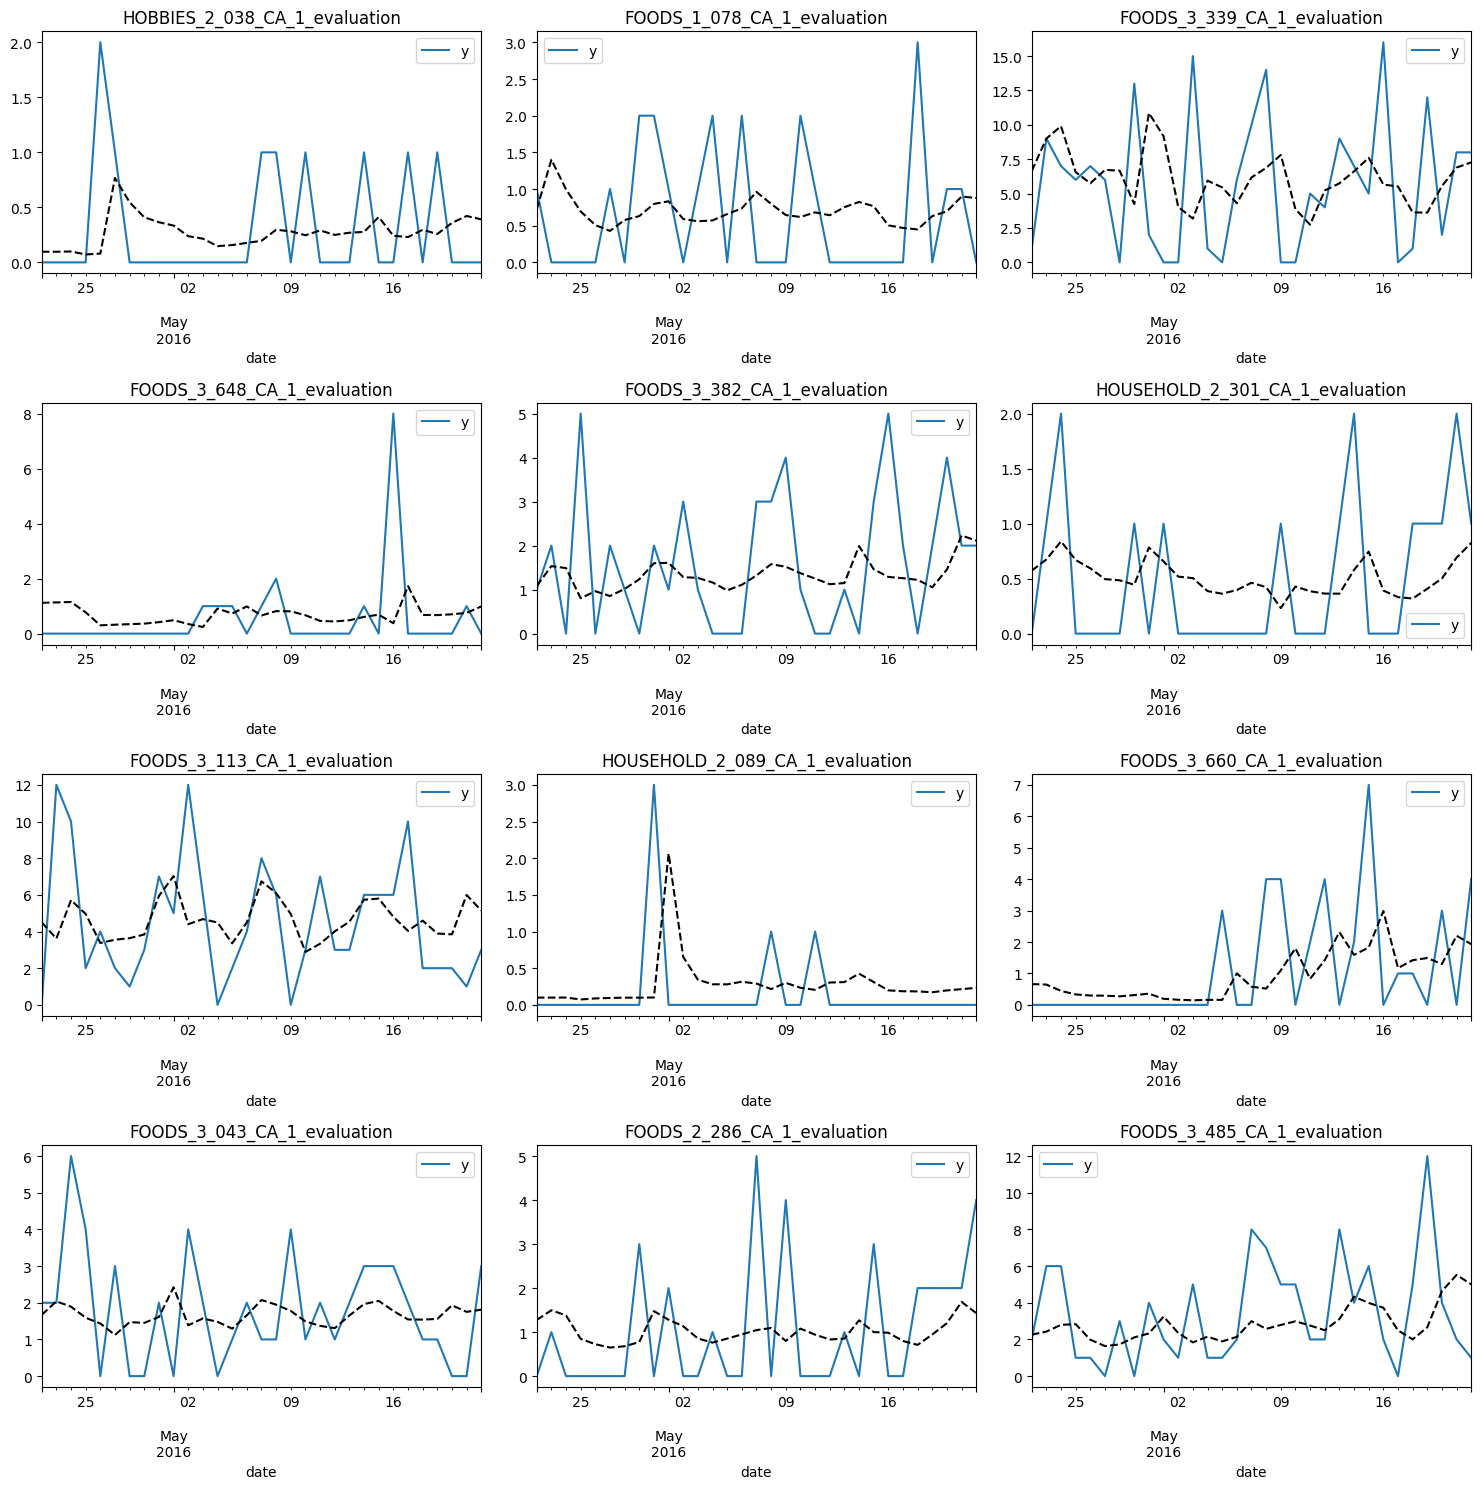

In [12]:
# Plot subset of forecasts
fig, ax = plt.subplots(nrows=n_series // 3, ncols=3, figsize=[15, 15])
for ix, ax in enumerate(ax.flatten()):
    ts_id = ts_ids[ix]
    # Plot actuals
    y_train_recent.loc[ts_id, ["y"]].plot(ax=ax)
    # Plot forecasts
    y_pred_train.loc[ts_id,"y_pred"].plot(
        ax=ax, linestyle="--", color="k"
    )
    ax.set_title(ts_id)
plt.tight_layout()
plt.show()